# Comparaison des Modèles YOLO

Ce notebook permet de charger les résultats de validation des différents modèles YOLO (v8, v10, v11) et de générer des graphiques de comparaison pour le mémoire.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import numpy as np
from matplotlib.ticker import FuncFormatter
from pathlib import Path

# Configuration du style pour des graphiques scientifiques
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## Chargement des Données

Nous allons lire tous les fichiers CSV du dossier courant et extraire les informations pertinentes.

In [38]:
def parse_filename(filename):
    """Extract model info from filename."""
    # Normalisation du nom de fichier pour gérer les typos et variations
    name = os.path.basename(filename).replace('.csv', '')
    
    # Regex pour capturer la version, la taille et si c'est pré-entraîné
    # Exemples: yolov11s.csv, yolov11s-petrain.csv, yolov8m_pretrain.csv
    match = re.search(r'(yolov\d+)([sm])', name)
    
    if match:
        version = match.group(1).upper() # ex: YOLOV11
        size = match.group(2).upper()    # ex: S
        model_name = f"{version}{size}"
    else:
        model_name = name
        version = "Unknown"
        size = "Unknown"
    
    # Détection du pré-entraînement
    is_pretrained = 'pretrain' in name or 'petrain' in name
    training_type = "Pretrained" if is_pretrained else "Scratch"
    
    return model_name, version, size, training_type

data = []
csv_files = glob.glob("*.csv")
csv_files = [f for f in csv_files if not f.endswith("all_results.csv")]


for file in csv_files:
    try:
        df = pd.read_csv(file)
        model_name, version, size, training_type = parse_filename(file)

        # On garde toutes les lignes (un test par dataset + global)
        for _, row in df.iterrows():
            data.append({
                "Model": model_name,
                "Version": version,
                "Size": size,
                "Training": training_type,
                "Source": row.get("source", "Unknown"),

                "mAP50-95": row.get("map50_95_mean", 0),
                "mAP50": row.get("map50_mean", 0),
                "mAP75": row.get("map75_mean", 0),
                "Precision": row.get("precision_mean", 0),
                "Recall": row.get("recall_mean", 0),
                "F1": row.get("f1_mean", 0),
                "Inference Time (ms)": row.get("speed_inf_ms_mean", 0),
                "Preprocessing Time (ms)": row.get("speed_pre_ms_mean", 0),
                "Postprocessing Time (ms)": row.get("speed_post_ms_mean", 0),
                "Total Time (ms)": row.get("speed_total_ms_mean", 0),
                "FPS": row.get("fps_est_mean", 0),
            })
    except Exception as e:
        print(f"Erreur lors de la lecture de {file}: {e}")

results_df = pd.DataFrame(data)


In [39]:
# =========================
# 2) Extraire le scénario synthétique (PCBE1, PCBE2, PCBE3, …)
# =========================

import re
import numpy as np

def extract_pcbe_scenario(model_name: str):
    """
    Retourne le scénario à partir du nom du fichier / modèle.

    Exemples supportés :
    - 'E1-seed1.csv'        -> 'PCBE1'
    - 'E2-seed2.csv'        -> 'PCBE2'
    - 'syntheticPCBE3.csv'  -> 'PCBE3'
    - 'aug.csv' / 'baseline.csv' -> 'Baseline'
    """
    name = str(model_name).lower()

    # Baseline (sans PCB synthétique)
    if (
        name.startswith("aug")
        or "baseline" in name
    ):
        return "Baseline"

    # Cas principal : E1, E2, E3, ...
    # Match :
    #   E1-seed1.csv
    #   e2_seed3.csv
    #   E3.csv
    m = re.search(r"\b[eE](\d+)\b", name)
    if m:
        return f"PCBE{m.group(1)}"

    return np.nan


# Nouvelle colonne qui indique le scénario (Baseline / PCBE1 / PCBE2 / PCBE3)
results_df["Scenario"] = results_df["Model"].apply(extract_pcbe_scenario)

# =========================
# 3) Agrégation (moyenne + variance) par scénario et par dataset
# =========================

metrics_cols = [
    "mAP50-95",
    "mAP50",
    "mAP75",
    "Precision",
    "Recall",
    "F1",
    "Inference Time (ms)",
    "Preprocessing Time (ms)",
    "Postprocessing Time (ms)",
    "Total Time (ms)",
    "FPS",
]

# On enlève les lignes sans scénario reconnu
df_for_stats = results_df.dropna(subset=["Scenario"])

# GroupBy par scénario (Baseline / PCBE1 / PCBE2 / PCBE3) ET par dataset (Source)
agg_df = (
    df_for_stats
    .groupby(["Scenario", "Source"])[metrics_cols]
    .agg(["mean", "var"])      # moyenne + variance sur les seeds
    .reset_index()
)

# Aplatir les colonnes MultiIndex
agg_df.columns = (
    ["Scenario", "Source"] +
    [f"{metric}_{stat}" for metric in metrics_cols for stat in ["mean", "var"]]
)

# Tri pour lisibilité
agg_df = agg_df.sort_values(["Scenario", "Source"])

# Sauvegarde optionnelle (tu peux changer le nom si tu veux)
agg_df.to_csv("syntheticPCBE_agg_results_by_dataset.csv", index=False)
results_df.head(100)


,Model,Version,Size,Training,Source,mAP50-95,mAP50,mAP75,Precision,Recall,F1,Inference Time (ms),Preprocessing Time (ms),Postprocessing Time (ms),Total Time (ms),FPS,Scenario
0,E3-seed1,Unknown,Unknown,Scratch,TestSet::dataset::datamatrixfit,0.338107,0.792659,0.138692,0.840708,0.678571,0.750988,18.740228,2.073498,1.615156,22.428882,44.585370,PCBE3
1,E3-seed1,Unknown,Unknown,Scratch,TestSet::dataset::pcbdataset,0.506253,0.873200,0.598941,0.923077,0.774194,0.842105,8.466122,1.212774,0.276229,9.955125,100.450770,PCBE3
2,E3-seed1,Unknown,Unknown,Scratch,TestSet::global::global,0.371534,0.818897,0.285523,0.837074,0.824744,0.830864,8.164931,0.197988,0.131647,8.494567,117.722306,PCBE3
3,E3-seed2,Unknown,Unknown,Scratch,TestSet::dataset::datamatrixfit,0.254001,0.655335,0.095269,0.737861,0.692857,0.714651,16.391254,2.092605,2.244024,20.727883,48.244194,PCBE3
4,E3-seed2,Unknown,Unknown,Scratch,TestSet::dataset::pcbdataset,0.488683,0.752622,0.586388,0.736893,0.677419,0.705906,11.755206,1.213738,0.113854,13.082798,76.436248,PCBE3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,aug-seed1,Unknown,Unknown,Scratch,TestSet::dataset::pcbdataset,0.503270,0.827535,0.550787,0.920000,0.741935,0.821429,22.229656,1.468481,2.337856,26.035994,38.408367,Baseline
95,aug-seed1,Unknown,Unknown,Scratch,TestSet::dataset::qrv2,0.682504,0.967456,0.796481,0.980166,0.938604,0.958935,20.140710,0.548299,2.224363,22.913371,43.642640,Baseline
96,aug-seed1,Unknown,Unknown,Scratch,TestSet::dataset::real2dcodes,0.635857,0.969154,0.859433,0.990659,0.931953,0.960409,20.243737,0.808351,2.249863,23.301951,42.914862,Baseline
97,aug-seed1,Unknown,Unknown,Scratch,TestSet::dataset::recntagledmtest,0.306603,0.917393,0.071907,0.811142,0.939597,0.870657,20.400129,0.647445,2.273305,23.320879,42.880031,Baseline


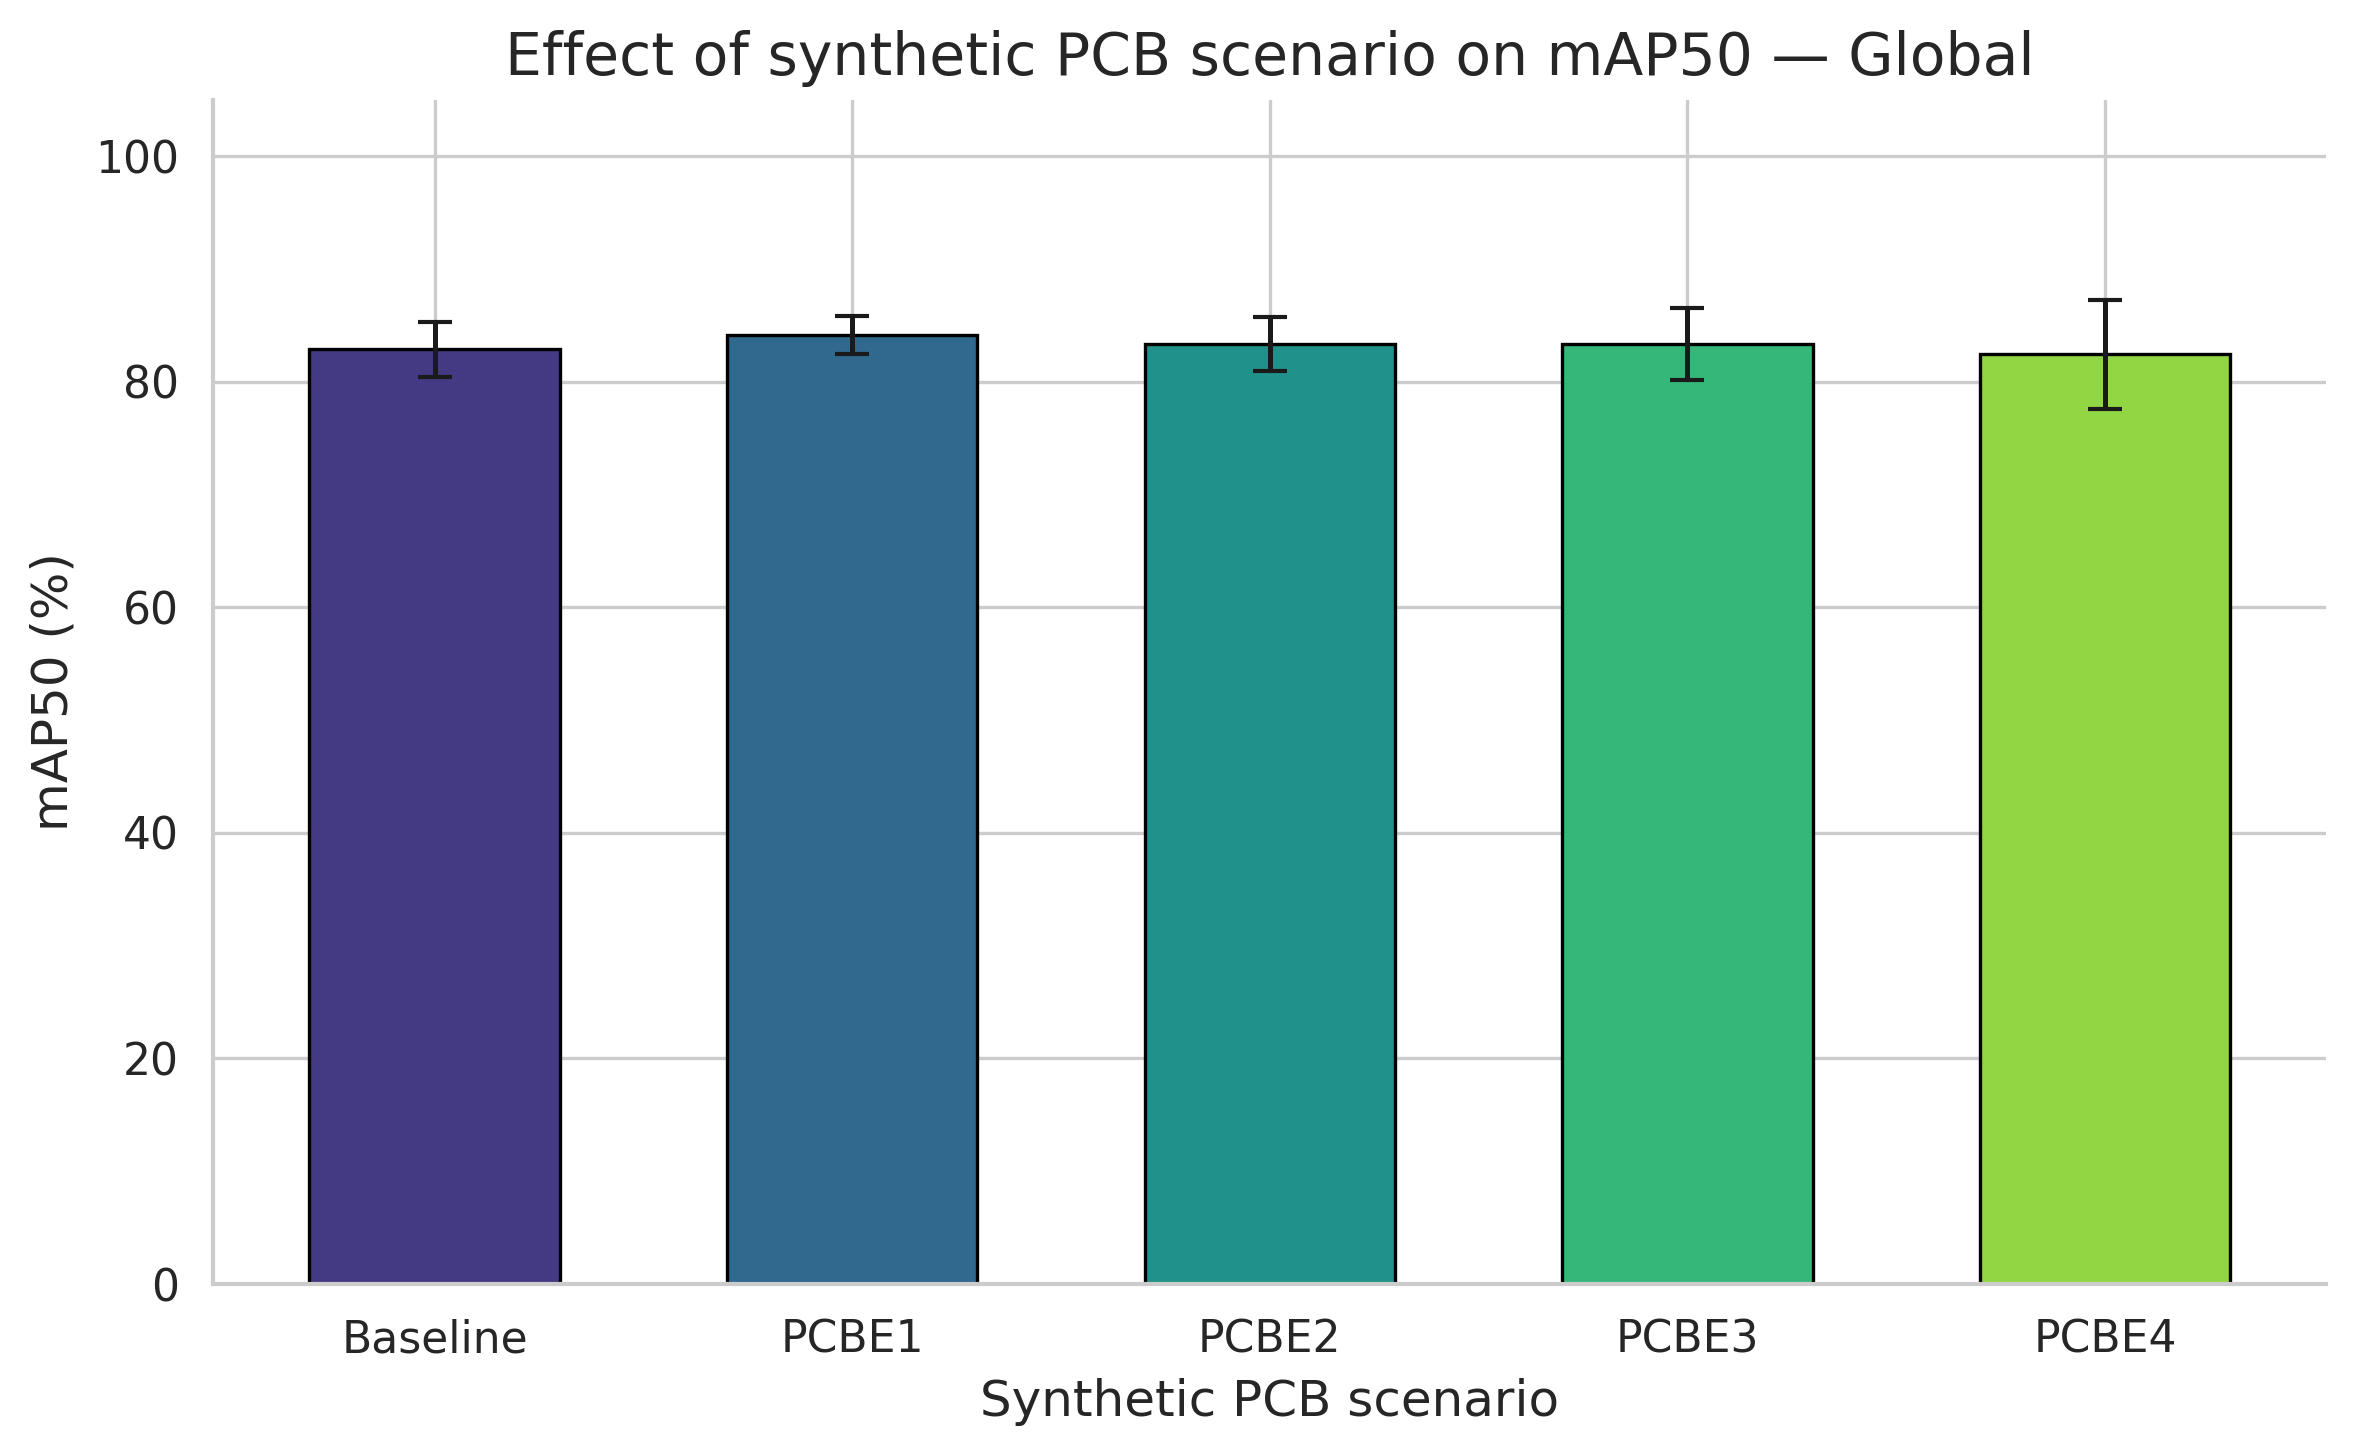

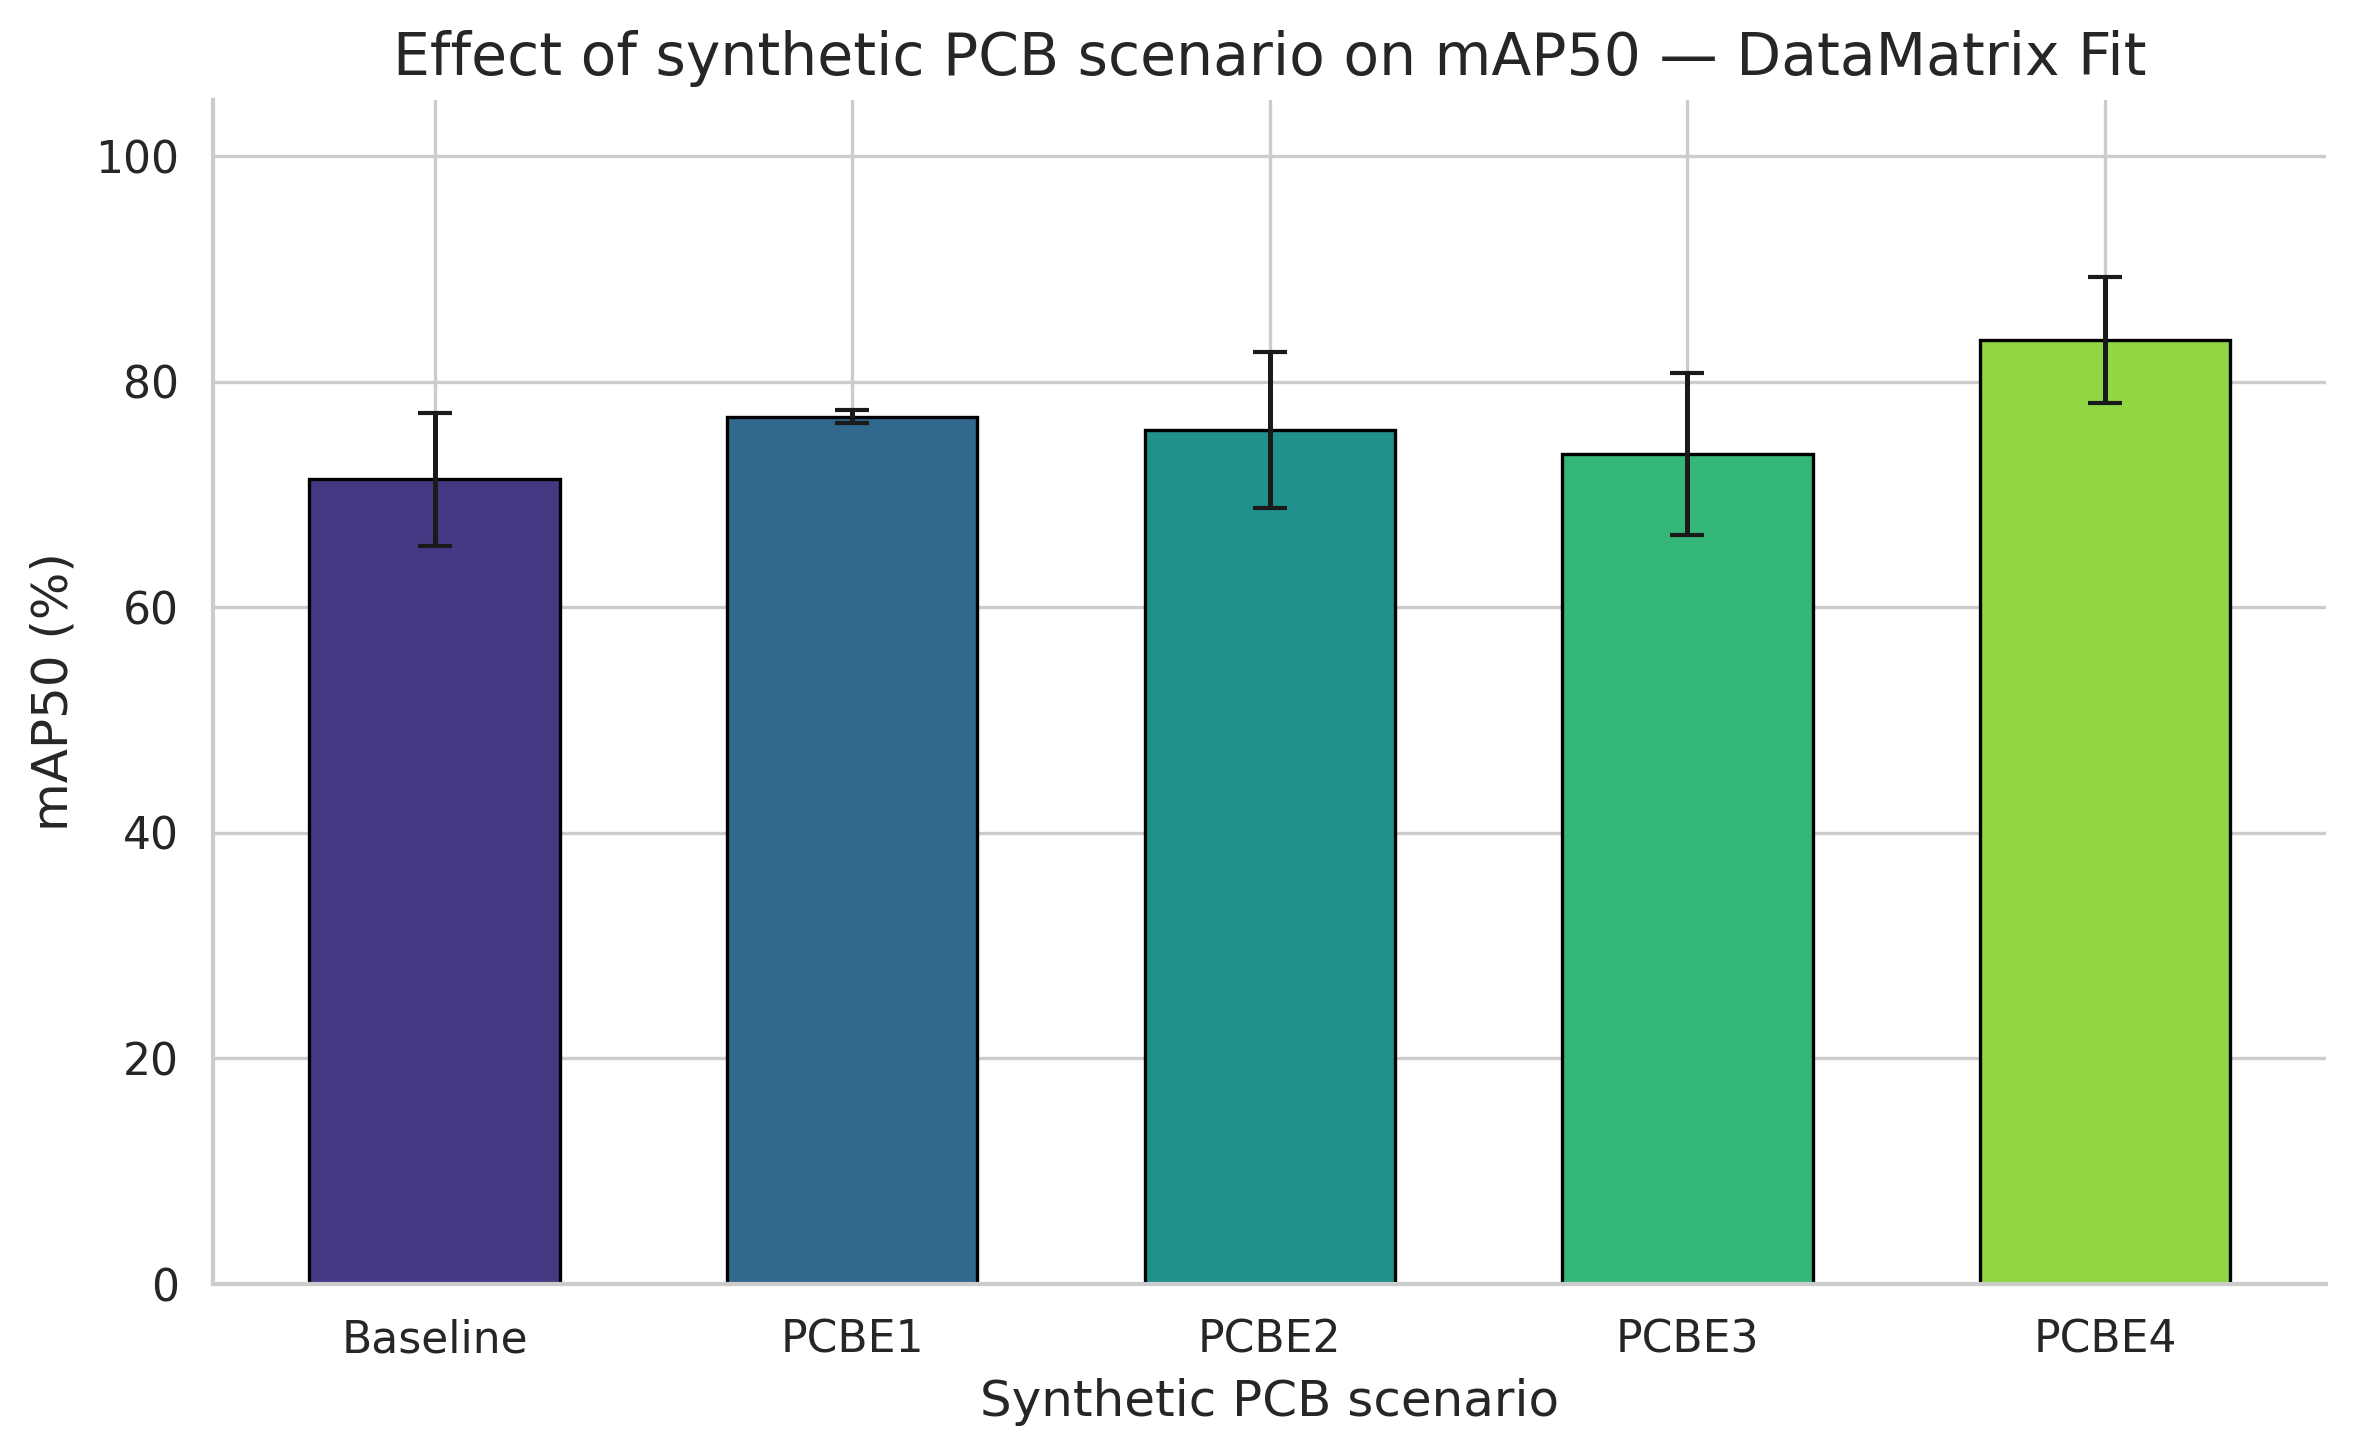

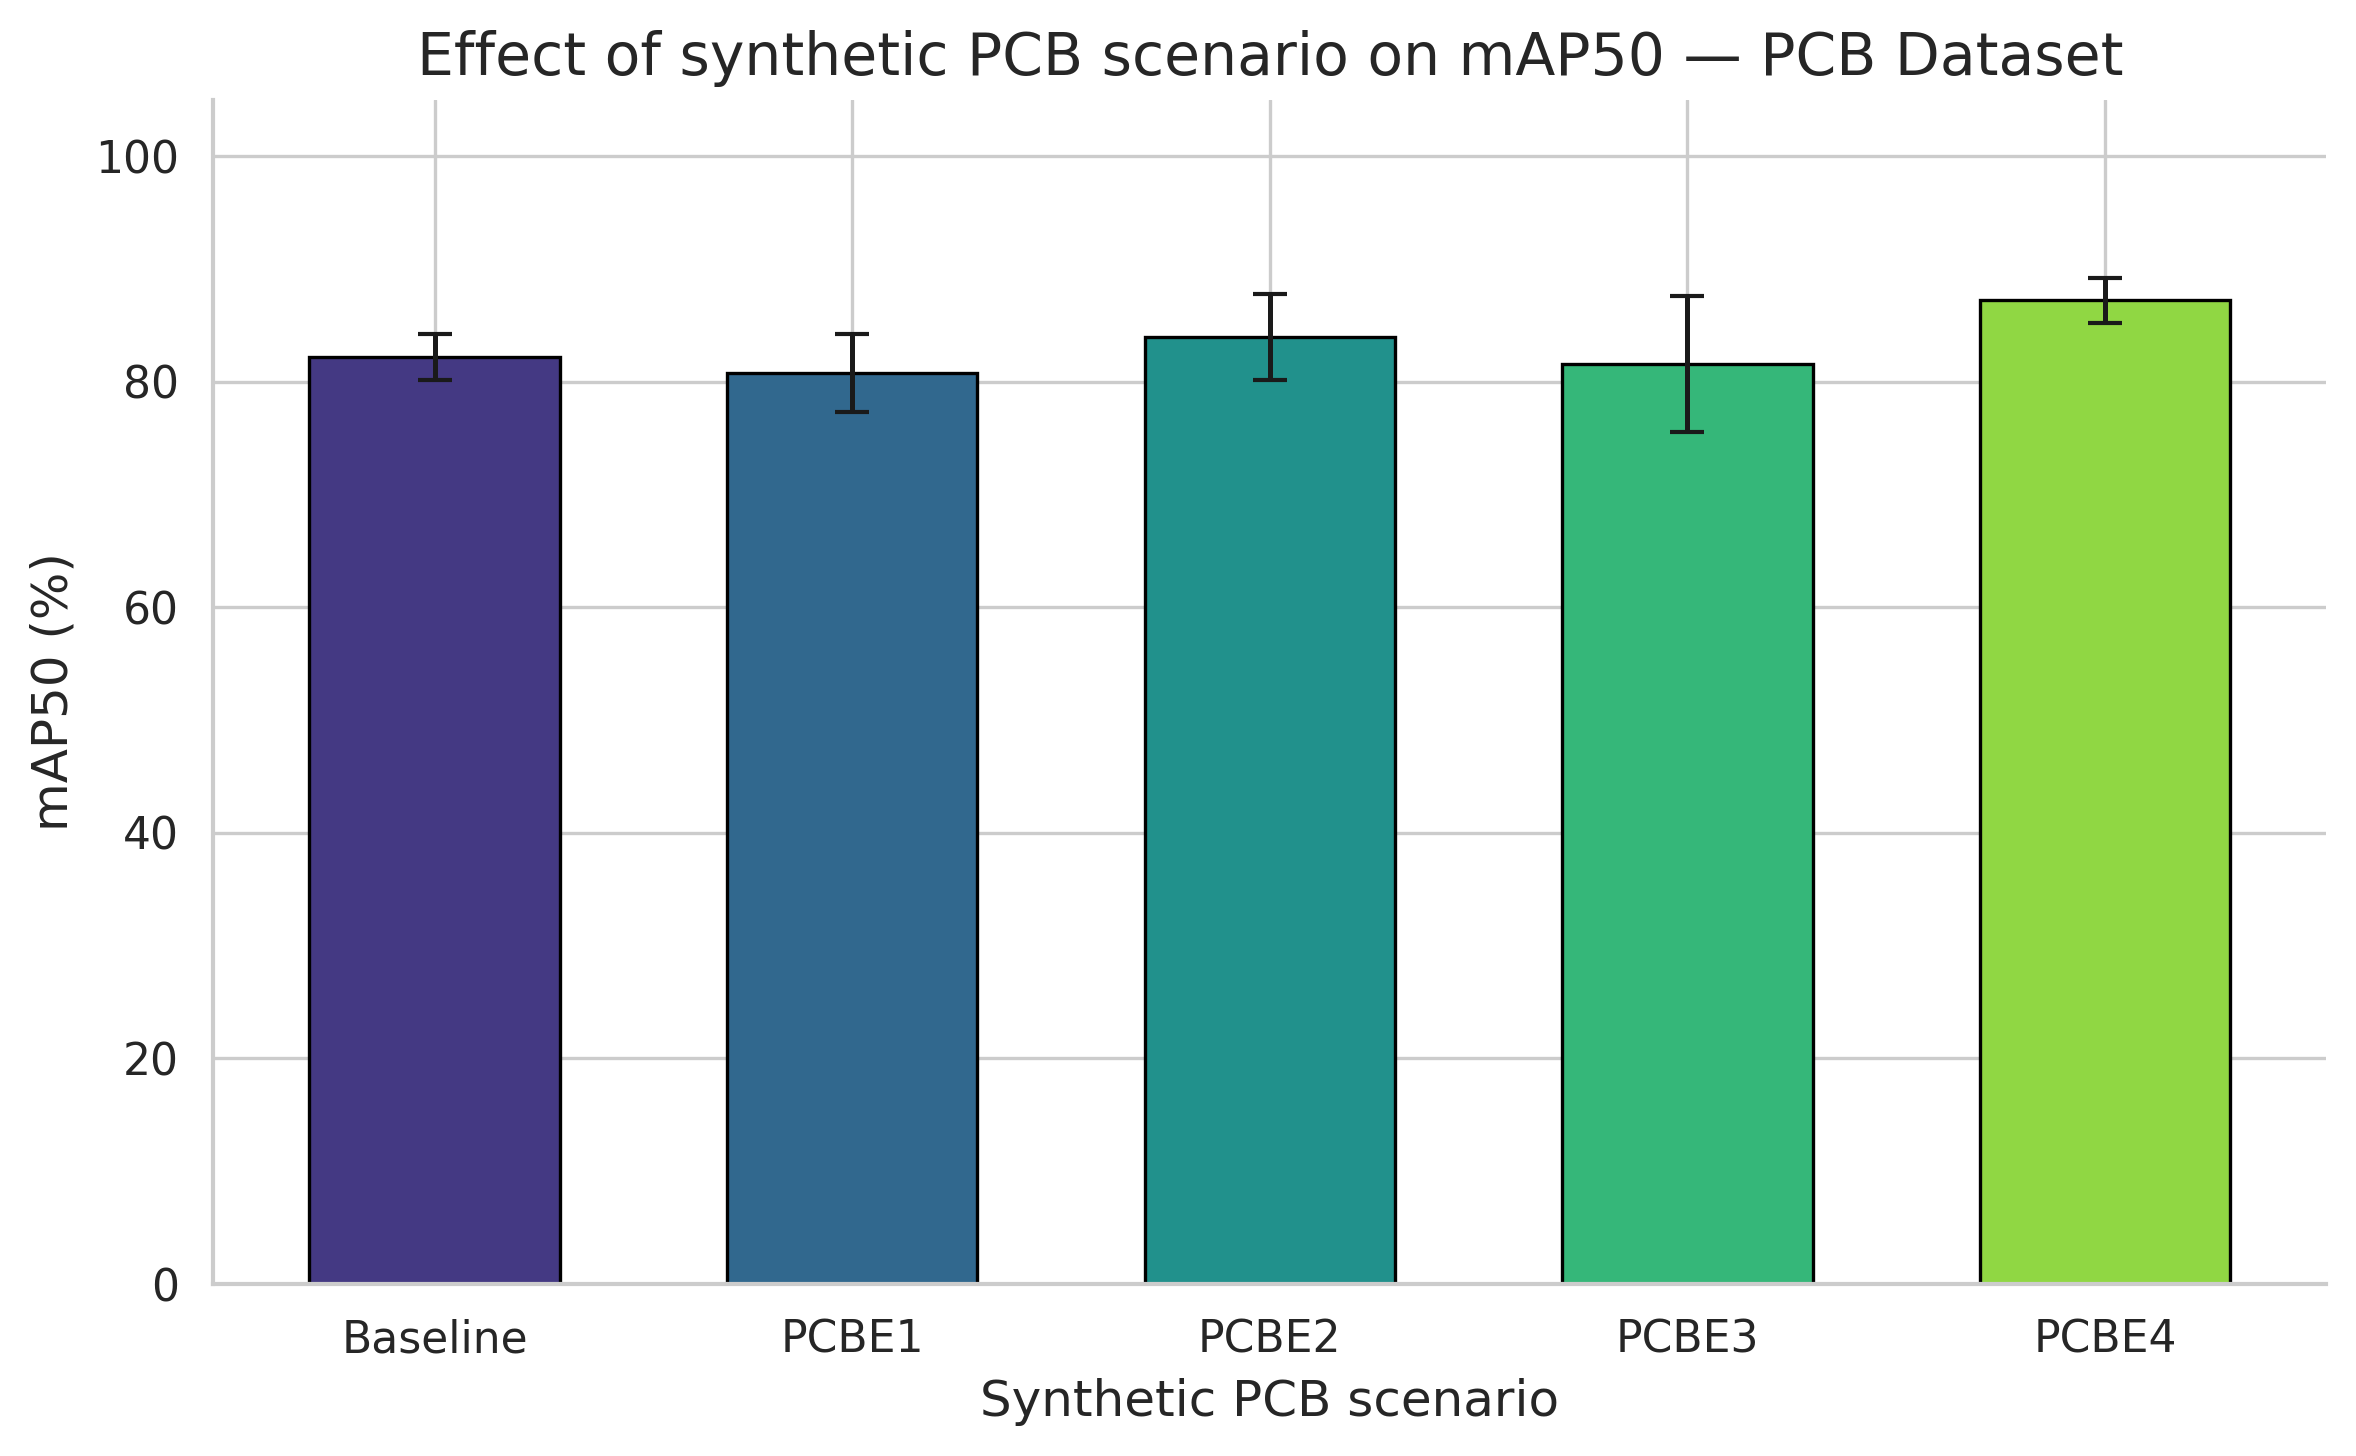

(    Scenario  mAP50_mean  mAP50_var
 8   Baseline    0.828597   0.000589
 17     PCBE1    0.841385   0.000272
 26     PCBE2    0.833430   0.000587
 29     PCBE3    0.833346   0.001022
 32     PCBE4    0.824330   0.002338,
     Scenario  mAP50_mean  mAP50_var
 1   Baseline    0.713461   0.003485
 10     PCBE1    0.768903   0.000031
 19     PCBE2    0.757215   0.004761
 27     PCBE3    0.736180   0.005160
 30     PCBE4    0.837014   0.003146,
     Scenario  mAP50_mean  mAP50_var
 4   Baseline    0.821902   0.000412
 13     PCBE1    0.807521   0.001178
 22     PCBE2    0.839399   0.001449
 28     PCBE3    0.815476   0.003654
 31     PCBE4    0.871920   0.000408)

In [40]:
# Section 1 — mAP50 (bar chart with variance)

SCENARIO_ORDER = ["Baseline", "PCBE1", "PCBE2", "PCBE3", "PCBE4"]

def plot_map50_for_source(source_name: str, display_name: str):
    """
    Plot mAP50 (mean ± variance) as a bar chart for a given source.
    One bar per scenario (Baseline, PCBE1, PCBE2, PCBE3).
    """
    df = agg_df[agg_df["Source"] == source_name].copy()

    if df.empty:
        print(f"No data found for source: {source_name}")
        return None

    # Ordonner les scénarios pour que les barres soient toujours dans le même ordre
    df["Scenario"] = pd.Categorical(df["Scenario"], SCENARIO_ORDER)
    df = df.sort_values("Scenario")

    # X positions equally spaced (categorical)
    x = np.arange(len(df))
    x_labels = df["Scenario"].tolist()

    # mAP50 in percent + standard deviation from variance
    y = df["mAP50_mean"] * 100
    y_err = np.sqrt(df["mAP50_var"]) * 100

    # Color palette for bars
    colors = sns.color_palette("viridis", len(df))

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(
        x, y,
        yerr=y_err,
        capsize=4,
        width=0.6,                  # thicker bars
        color=colors,
        edgecolor="black",
        linewidth=0.8
    )

    ax.set_xlabel("Synthetic PCB scenario")
    ax.set_ylabel("mAP50 (%)")
    ax.set_title(f"Effect of synthetic PCB scenario on mAP50 — {display_name}")

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)

    ax.set_ylim(0, 105)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # Return numeric values for traceability in the notebook
    return df[["Scenario", "mAP50_mean", "mAP50_var"]]


# --- Calls for the three requested datasets ---

global_map50_stats = plot_map50_for_source(
    "TestSet::global::global",
    "Global"
)

datamatrixfit_map50_stats = plot_map50_for_source(
    "TestSet::dataset::datamatrixfit",
    "DataMatrix Fit"
)

pcbdataset_map50_stats = plot_map50_for_source(
    "TestSet::dataset::pcbdataset",
    "PCB Dataset"
)

global_map50_stats, datamatrixfit_map50_stats, pcbdataset_map50_stats


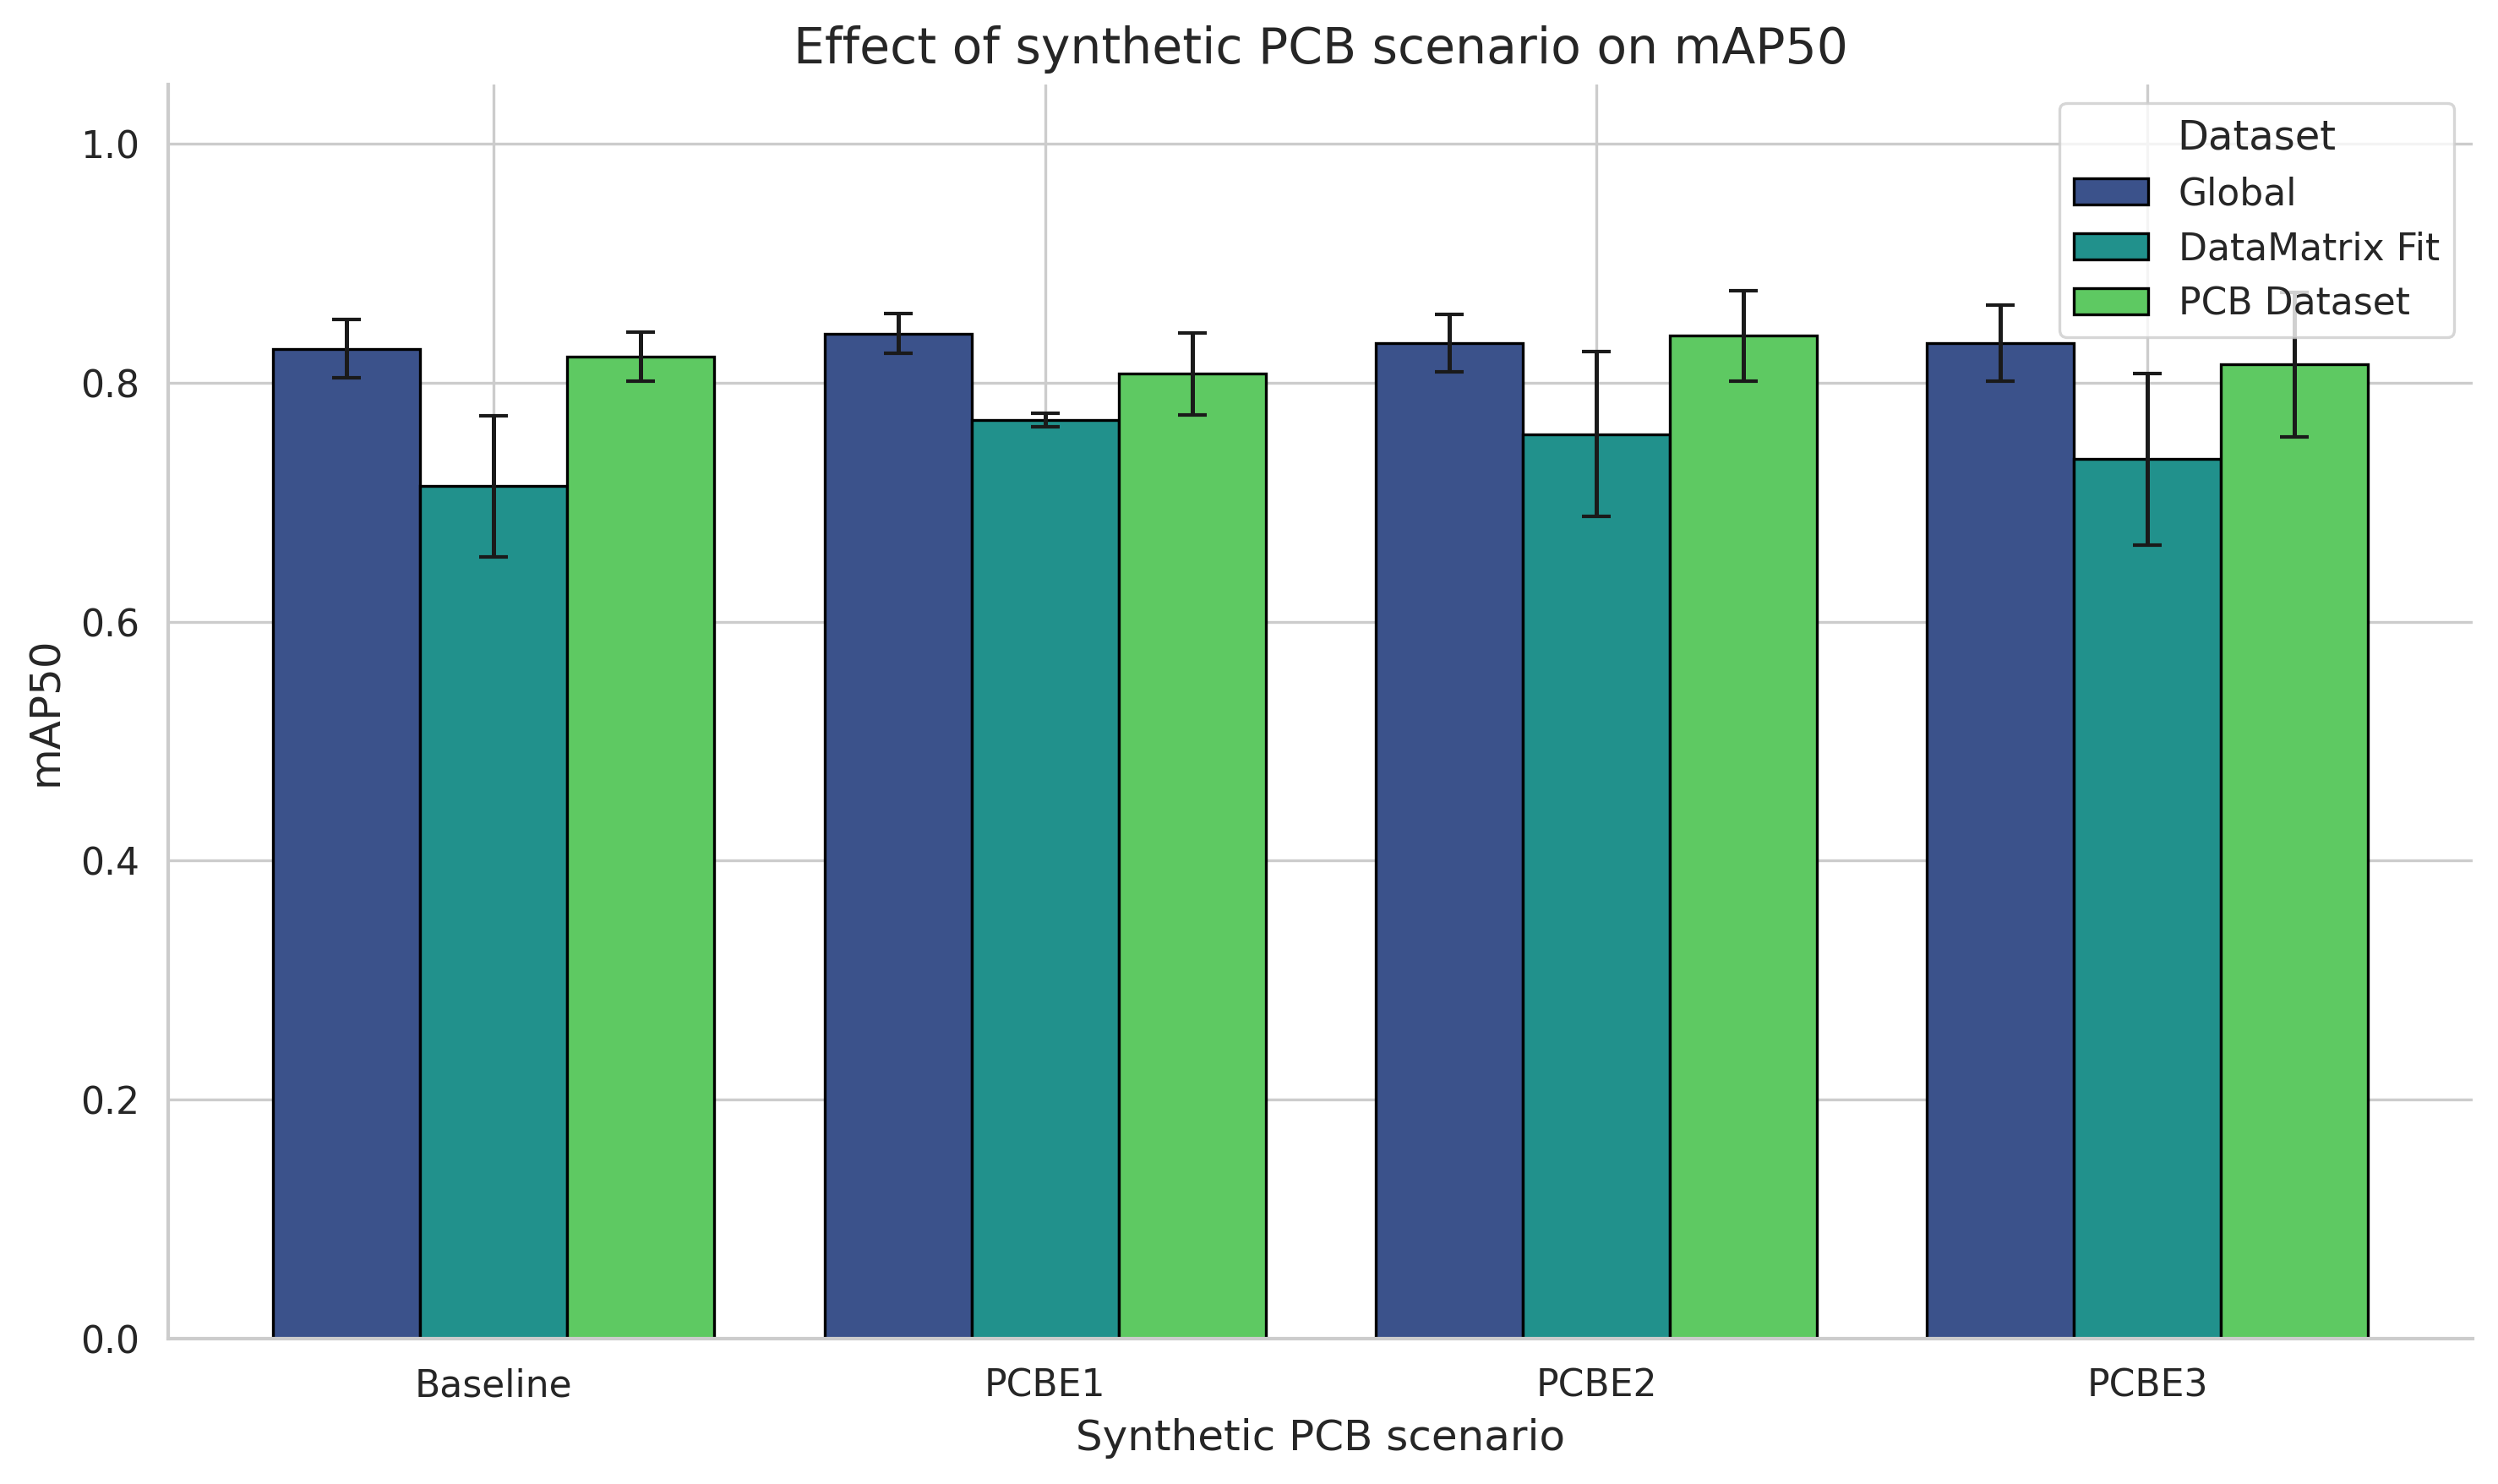

(Source    TestSet::dataset::datamatrixfit  TestSet::dataset::pcbdataset  \
 Scenario                                                                  
 Baseline                         0.713461                      0.821902   
 PCBE1                            0.768903                      0.807521   
 PCBE2                            0.757215                      0.839399   
 PCBE3                            0.736180                      0.815476   
 
 Source    TestSet::global::global  
 Scenario                           
 Baseline                 0.828597  
 PCBE1                    0.841385  
 PCBE2                    0.833430  
 PCBE3                    0.833346  ,
 Source    TestSet::dataset::datamatrixfit  TestSet::dataset::pcbdataset  \
 Scenario                                                                  
 Baseline                         0.003485                      0.000412   
 PCBE1                            0.000031                      0.001178   
 PCBE2         

In [41]:
SCENARIO_ORDER = ["Baseline", "PCBE1", "PCBE2", "PCBE3"]

def plot_map50_combined(sources):
    """
    Plot combined mAP50 (mean ± variance) for multiple sources on one bar chart.
    - sources: list of (source_name, display_name)
    - un groupe de barres par scénario (Baseline, PCBE1, PCBE2, PCBE3),
      et une barre par dataset à l'intérieur de chaque groupe.
    """
    source_names = [s[0] for s in sources]
    display_names = {s[0]: s[1] for s in sources}

    # Filtrer uniquement les sources d'intérêt
    df = agg_df[agg_df["Source"].isin(source_names)][
        ["Source", "Scenario", "mAP50_mean", "mAP50_var"]
    ].copy()

    if df.empty:
        print("No data found for the given sources.")
        return None

    # Ordonner les scénarios pour qu'ils soient toujours dans le même ordre
    df["Scenario"] = pd.Categorical(df["Scenario"], SCENARIO_ORDER)
    df = df.dropna(subset=["Scenario"])

    # Pivot pour obtenir une table Scenario x Source
    pivot_mean = df.pivot(index="Scenario", columns="Source", values="mAP50_mean")
    pivot_var  = df.pivot(index="Scenario", columns="Source", values="mAP50_var")

    # Ordonner les scénarios selon SCENARIO_ORDER, en gardant uniquement ceux présents
    scenarios_sorted = [s for s in SCENARIO_ORDER if s in pivot_mean.index]
    pivot_mean = pivot_mean.loc[scenarios_sorted]
    pivot_var  = pivot_var.loc[scenarios_sorted]

    n_scen = len(scenarios_sorted)
    n_src  = len(source_names)

    # Positions de groupes (un groupe par scénario)
    x = np.arange(n_scen)

    group_width = 0.8
    bar_width = group_width / n_src

    fig, ax = plt.subplots(figsize=(10, 6))

    palette = sns.color_palette("viridis", n_src)

    for i, src in enumerate(source_names):
        # Position d e ce dataset dans chaque groupe
        x_pos = x - group_width/2 + (i + 0.5) * bar_width

        y = pivot_mean[src]
        y_err = np.sqrt(pivot_var[src])

        ax.bar(
            x_pos, y,
            yerr=y_err,
            capsize=4,
            width=bar_width,
            color=palette[i],
            edgecolor="black",
            linewidth=0.8,
            label=display_names[src]
        )

    ax.set_xlabel("Synthetic PCB scenario")
    ax.set_ylabel("mAP50")
    ax.set_title("Effect of synthetic PCB scenario on mAP50")

    ax.set_xticks(x)
    ax.set_xticklabels(scenarios_sorted)

    ax.set_ylim(0.0, 1.05)
    ax.legend(frameon=True, title="Dataset")

    sns.despine()
    plt.tight_layout()
    plt.show()

    # Renvoie les tableaux pour traçabilité
    return pivot_mean, pivot_var


# Appel combiné pour Global, DataMatrixFit et PCBDataset
combined_mean, combined_var = plot_map50_combined([
    ("TestSet::global::global",        "Global"),
    ("TestSet::dataset::datamatrixfit","DataMatrix Fit"),
    ("TestSet::dataset::pcbdataset",   "PCB Dataset"),
])

combined_mean, combined_var


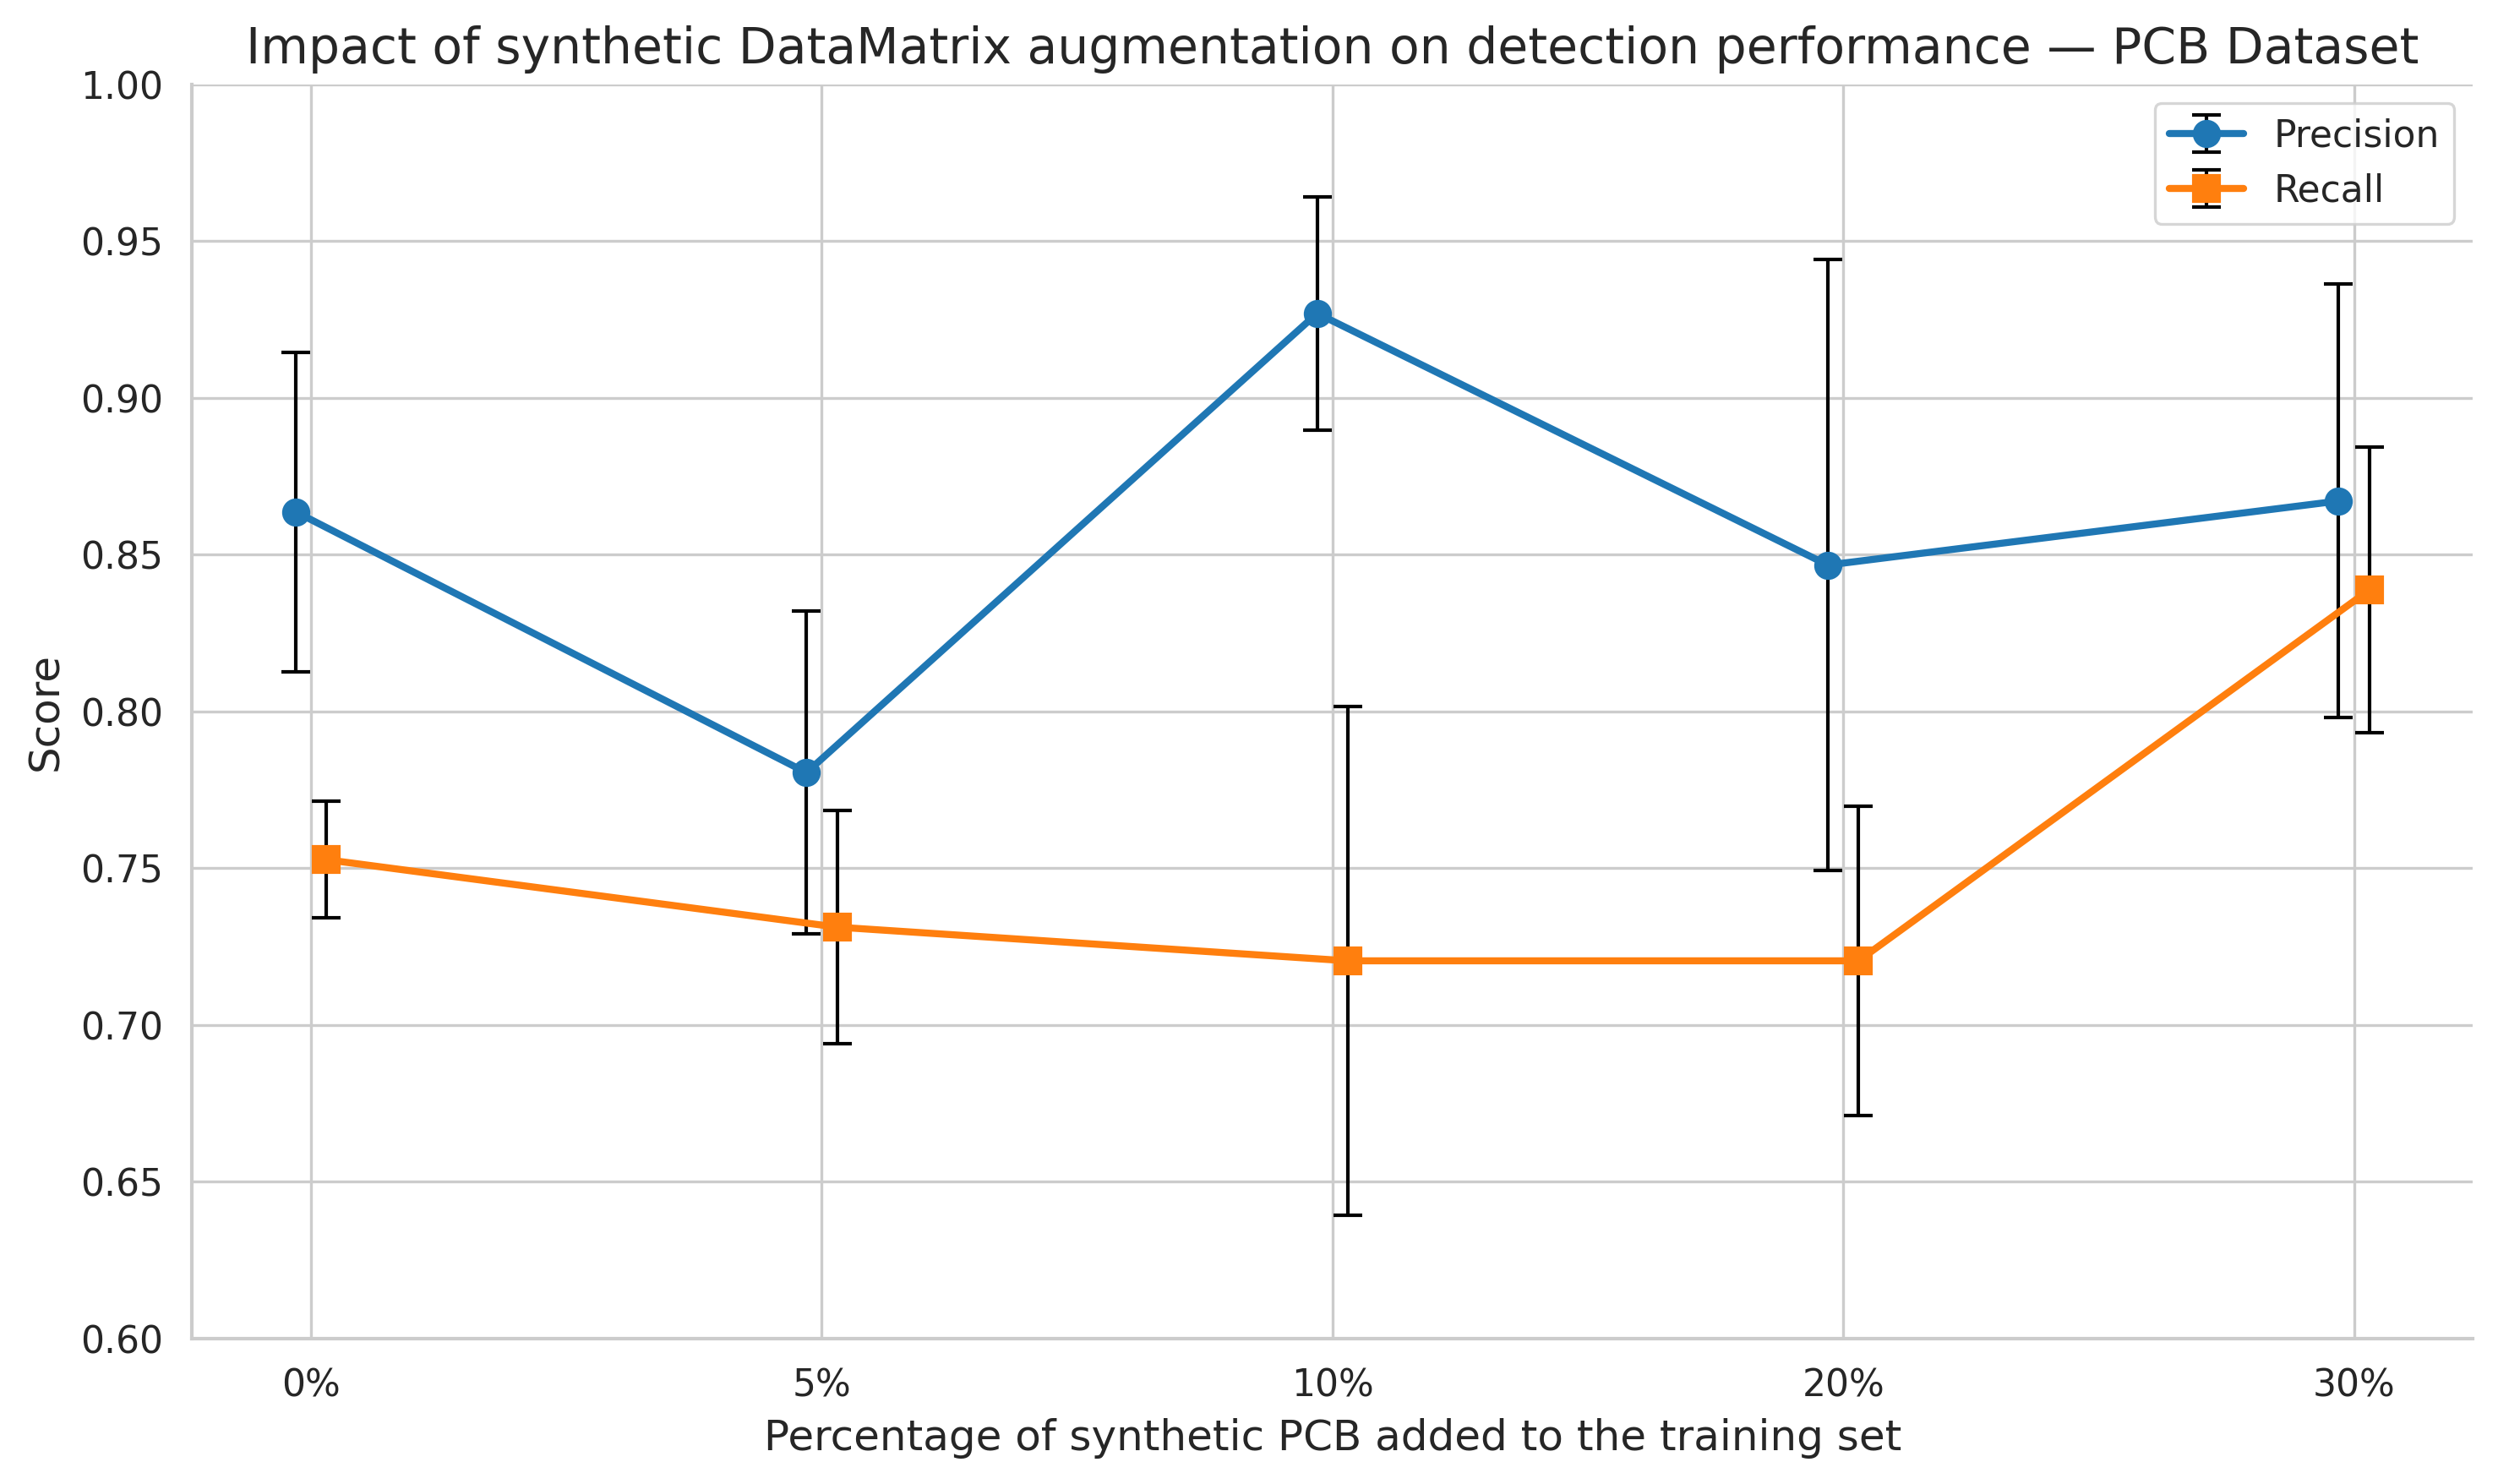

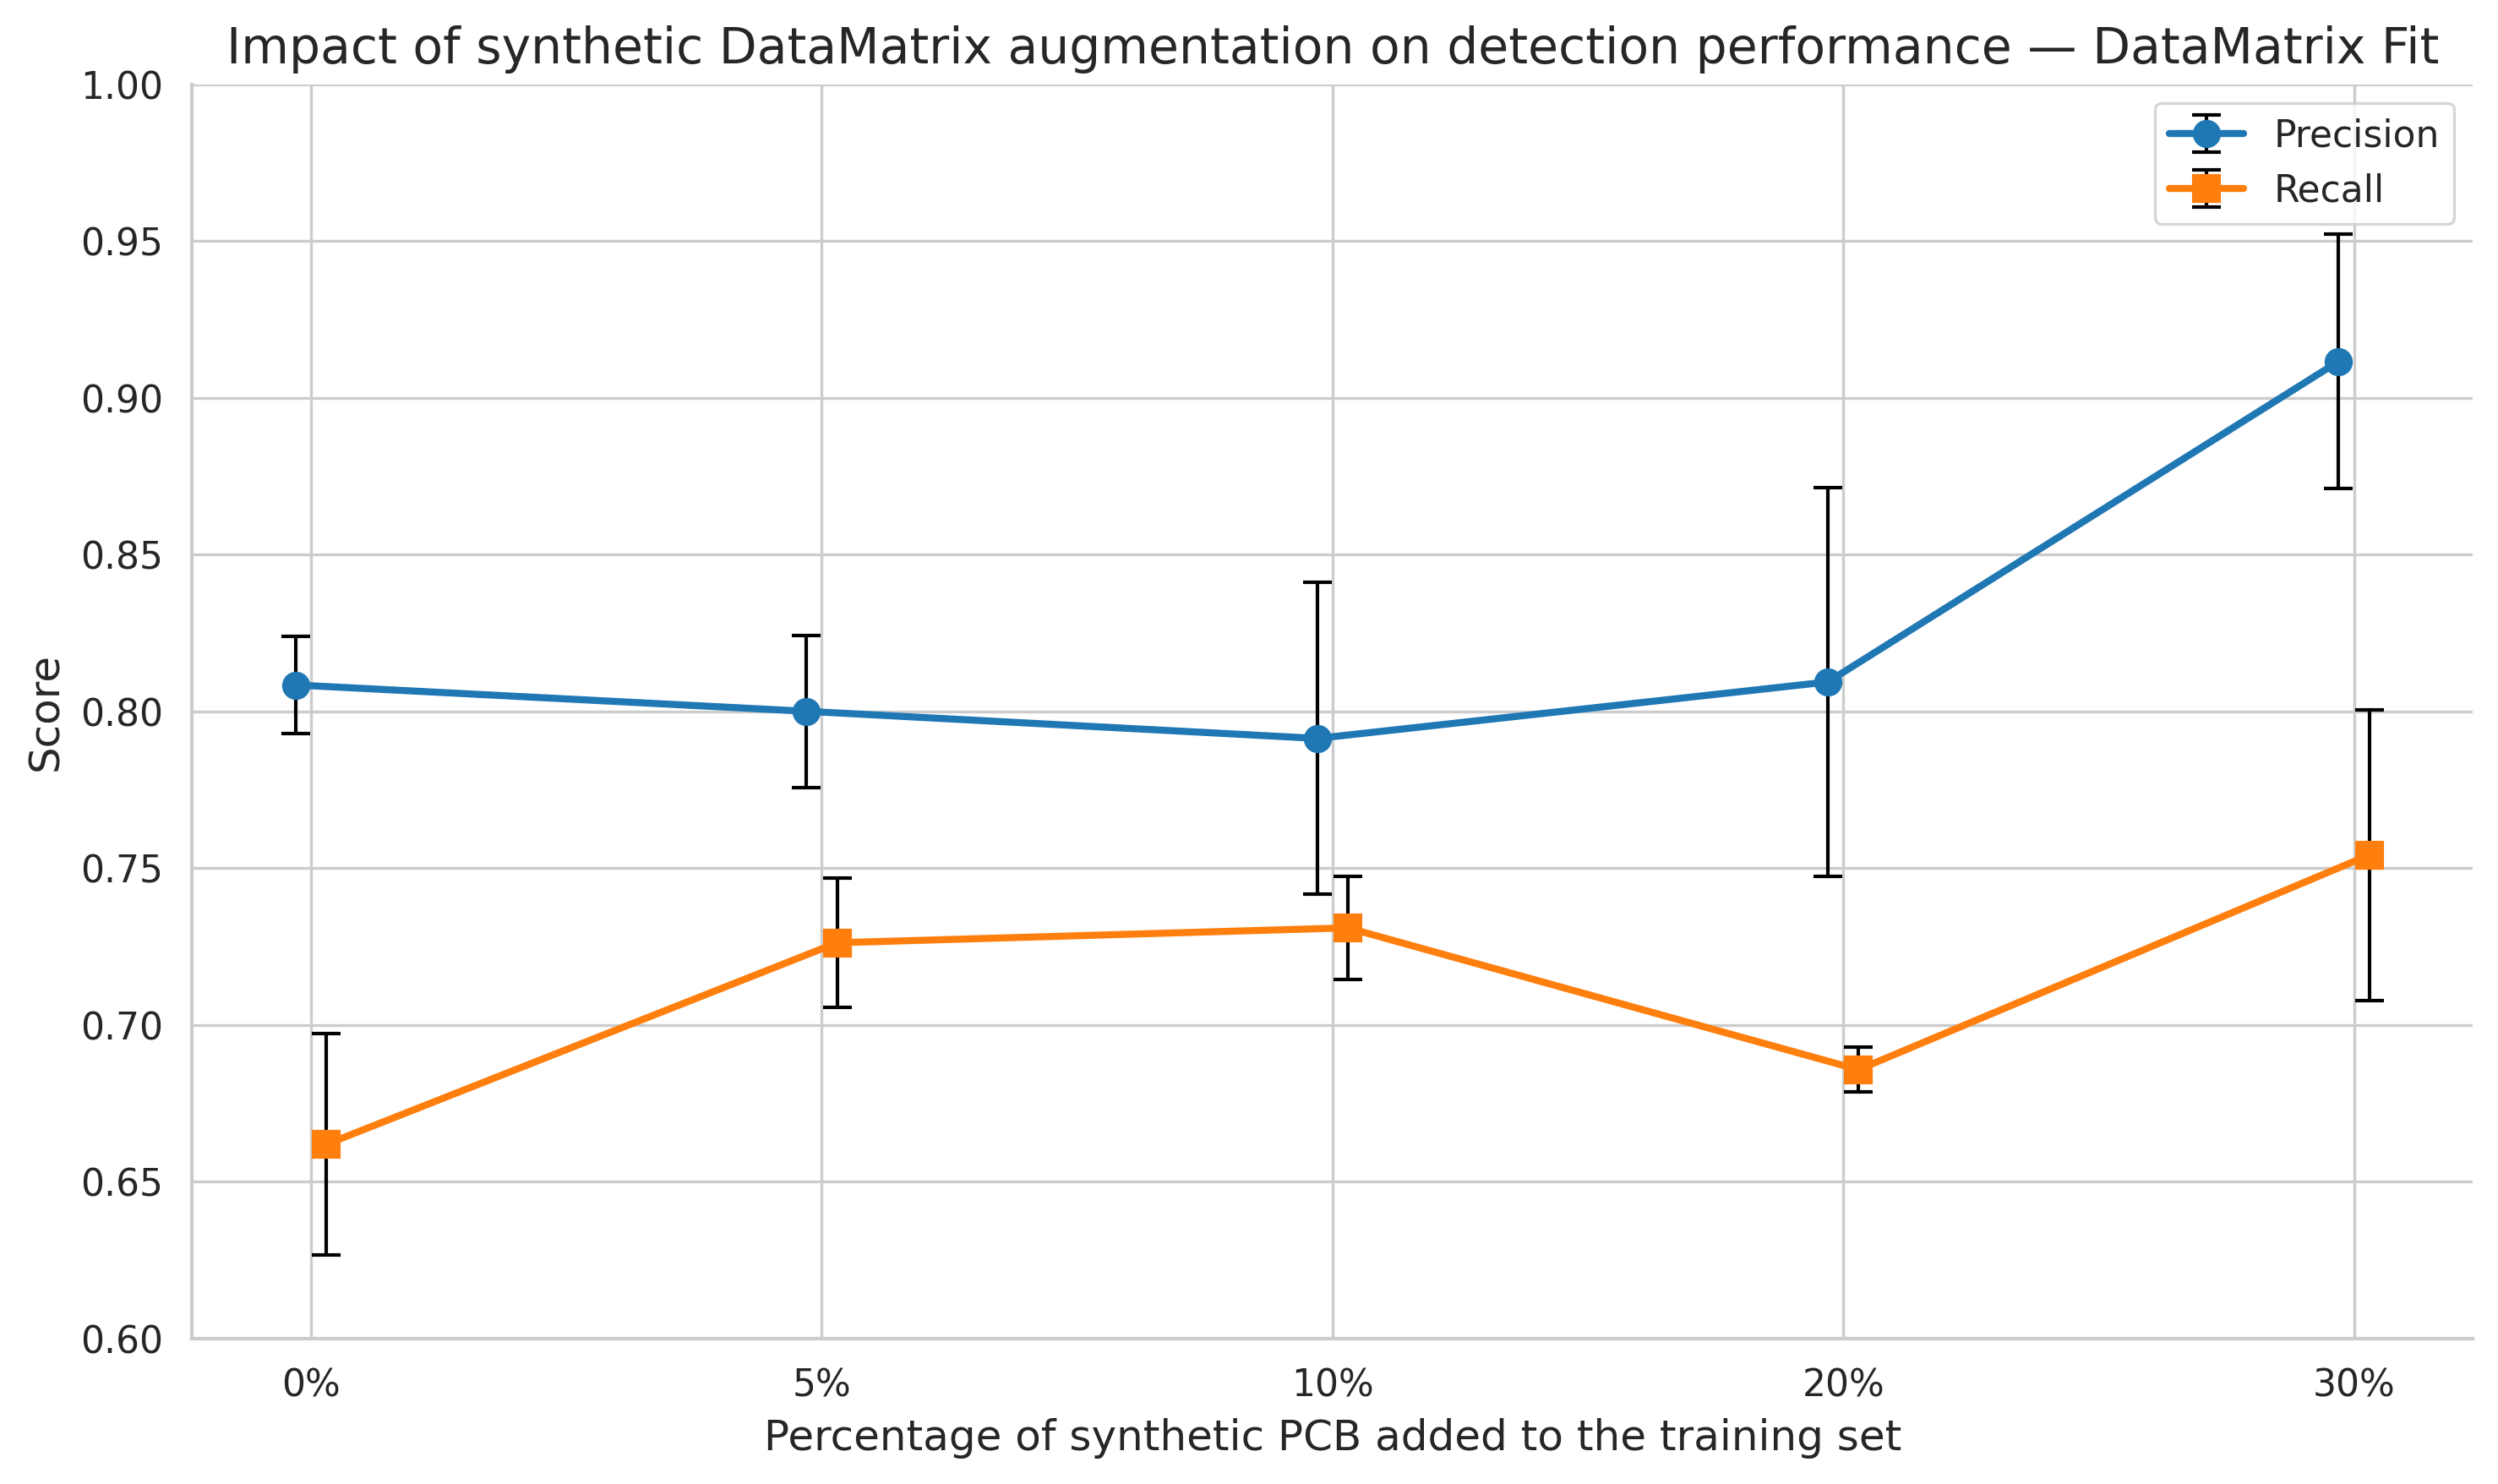

(    Scenario                        Source  mAP50-95_mean  mAP50-95_var  \
 4   Baseline  TestSet::dataset::pcbdataset       0.506552      0.000058   
 13     PCBE1  TestSet::dataset::pcbdataset       0.502080      0.000659   
 22     PCBE2  TestSet::dataset::pcbdataset       0.513186      0.000109   
 28     PCBE3  TestSet::dataset::pcbdataset       0.487386      0.000382   
 31     PCBE4  TestSet::dataset::pcbdataset       0.529701      0.000195   
 
     mAP50_mean  mAP50_var  mAP75_mean  mAP75_var  Precision_mean  \
 4     0.821902   0.000412    0.579303   0.000725        0.863625   
 13    0.807521   0.001178    0.628594   0.002711        0.780454   
 22    0.839399   0.001449    0.598335   0.001863        0.926932   
 28    0.815476   0.003654    0.571170   0.001425        0.846657   
 31    0.871920   0.000408    0.605807   0.000043        0.867090   
 
     Precision_var  ...  Inference Time (ms)_mean  Inference Time (ms)_var  \
 4        0.002595  ...                 15.60544

In [52]:
SCENARIO_ORDER = ["Baseline", "PCBE1", "PCBE2", "PCBE3", "PCBE4"]

def plot_precision_recall_for_dataset(source_name: str, display_name: str):
    # Filtrer le dataset demandé
    df = agg_df[agg_df["Source"] == source_name].copy()

    if df.empty:
        print(f"No data found for source: {source_name}")
        return None

    # Ordonner les scénarios pour un affichage cohérent
    df["Scenario"] = pd.Categorical(df["Scenario"], SCENARIO_ORDER)
    df = df.dropna(subset=["Scenario"]).sort_values("Scenario")

    # Convertir en axe X numérique
    x = np.arange(len(df))
    labels = ["0%","5%","10%","20%","30%"]

    # Décalage horizontal entre Precision et Recall
    offset = 0.03
    x_prec = x - offset
    x_rec = x + offset

    prec = df["Precision_mean"]
    rec = df["Recall_mean"]
    prec_err = np.sqrt(df["Precision_var"])
    rec_err = np.sqrt(df["Recall_var"])

    fig, ax = plt.subplots(figsize=(10, 6))

    # Precision
    ax.errorbar(
        x_prec, prec, yerr=prec_err,
        marker="o", markersize=7,
        linestyle="-", linewidth=2,
        color="#1f77b4",
        ecolor="black", elinewidth=1, capsize=4,
        label="Precision"
    )

    # Recall
    ax.errorbar(
        x_rec, rec, yerr=rec_err,
        marker="s", markersize=7,
        linestyle="-", linewidth=2,
        color="#ff7f0e",
        ecolor="black", elinewidth=1, capsize=4,
        label="Recall"
    )

    # Mise en forme
    ax.set_xlabel("Percentage of synthetic PCB added to the training set")
    ax.set_ylabel("Score")
    ax.set_title(f"Impact of synthetic DataMatrix augmentation on detection performance — {display_name}")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    if "datamatrix" in source_name:
        ax.set_ylim(0.6, 1.00)
    else:
        ax.set_ylim(0.6, 1.00)

    ax.legend(frameon=True)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f"precision_recall_{source_name.replace('::', '_')}.png")
    plt.show()

    return df


# 2 graphiques pour pcbdataset et datamatrixfit
pcbdataset_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::pcbdataset",
    "PCB Dataset"
)

datamatrixfit_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::datamatrixfit",
    "DataMatrix Fit"
)

pcbdataset_stats, datamatrixfit_stats


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (5).

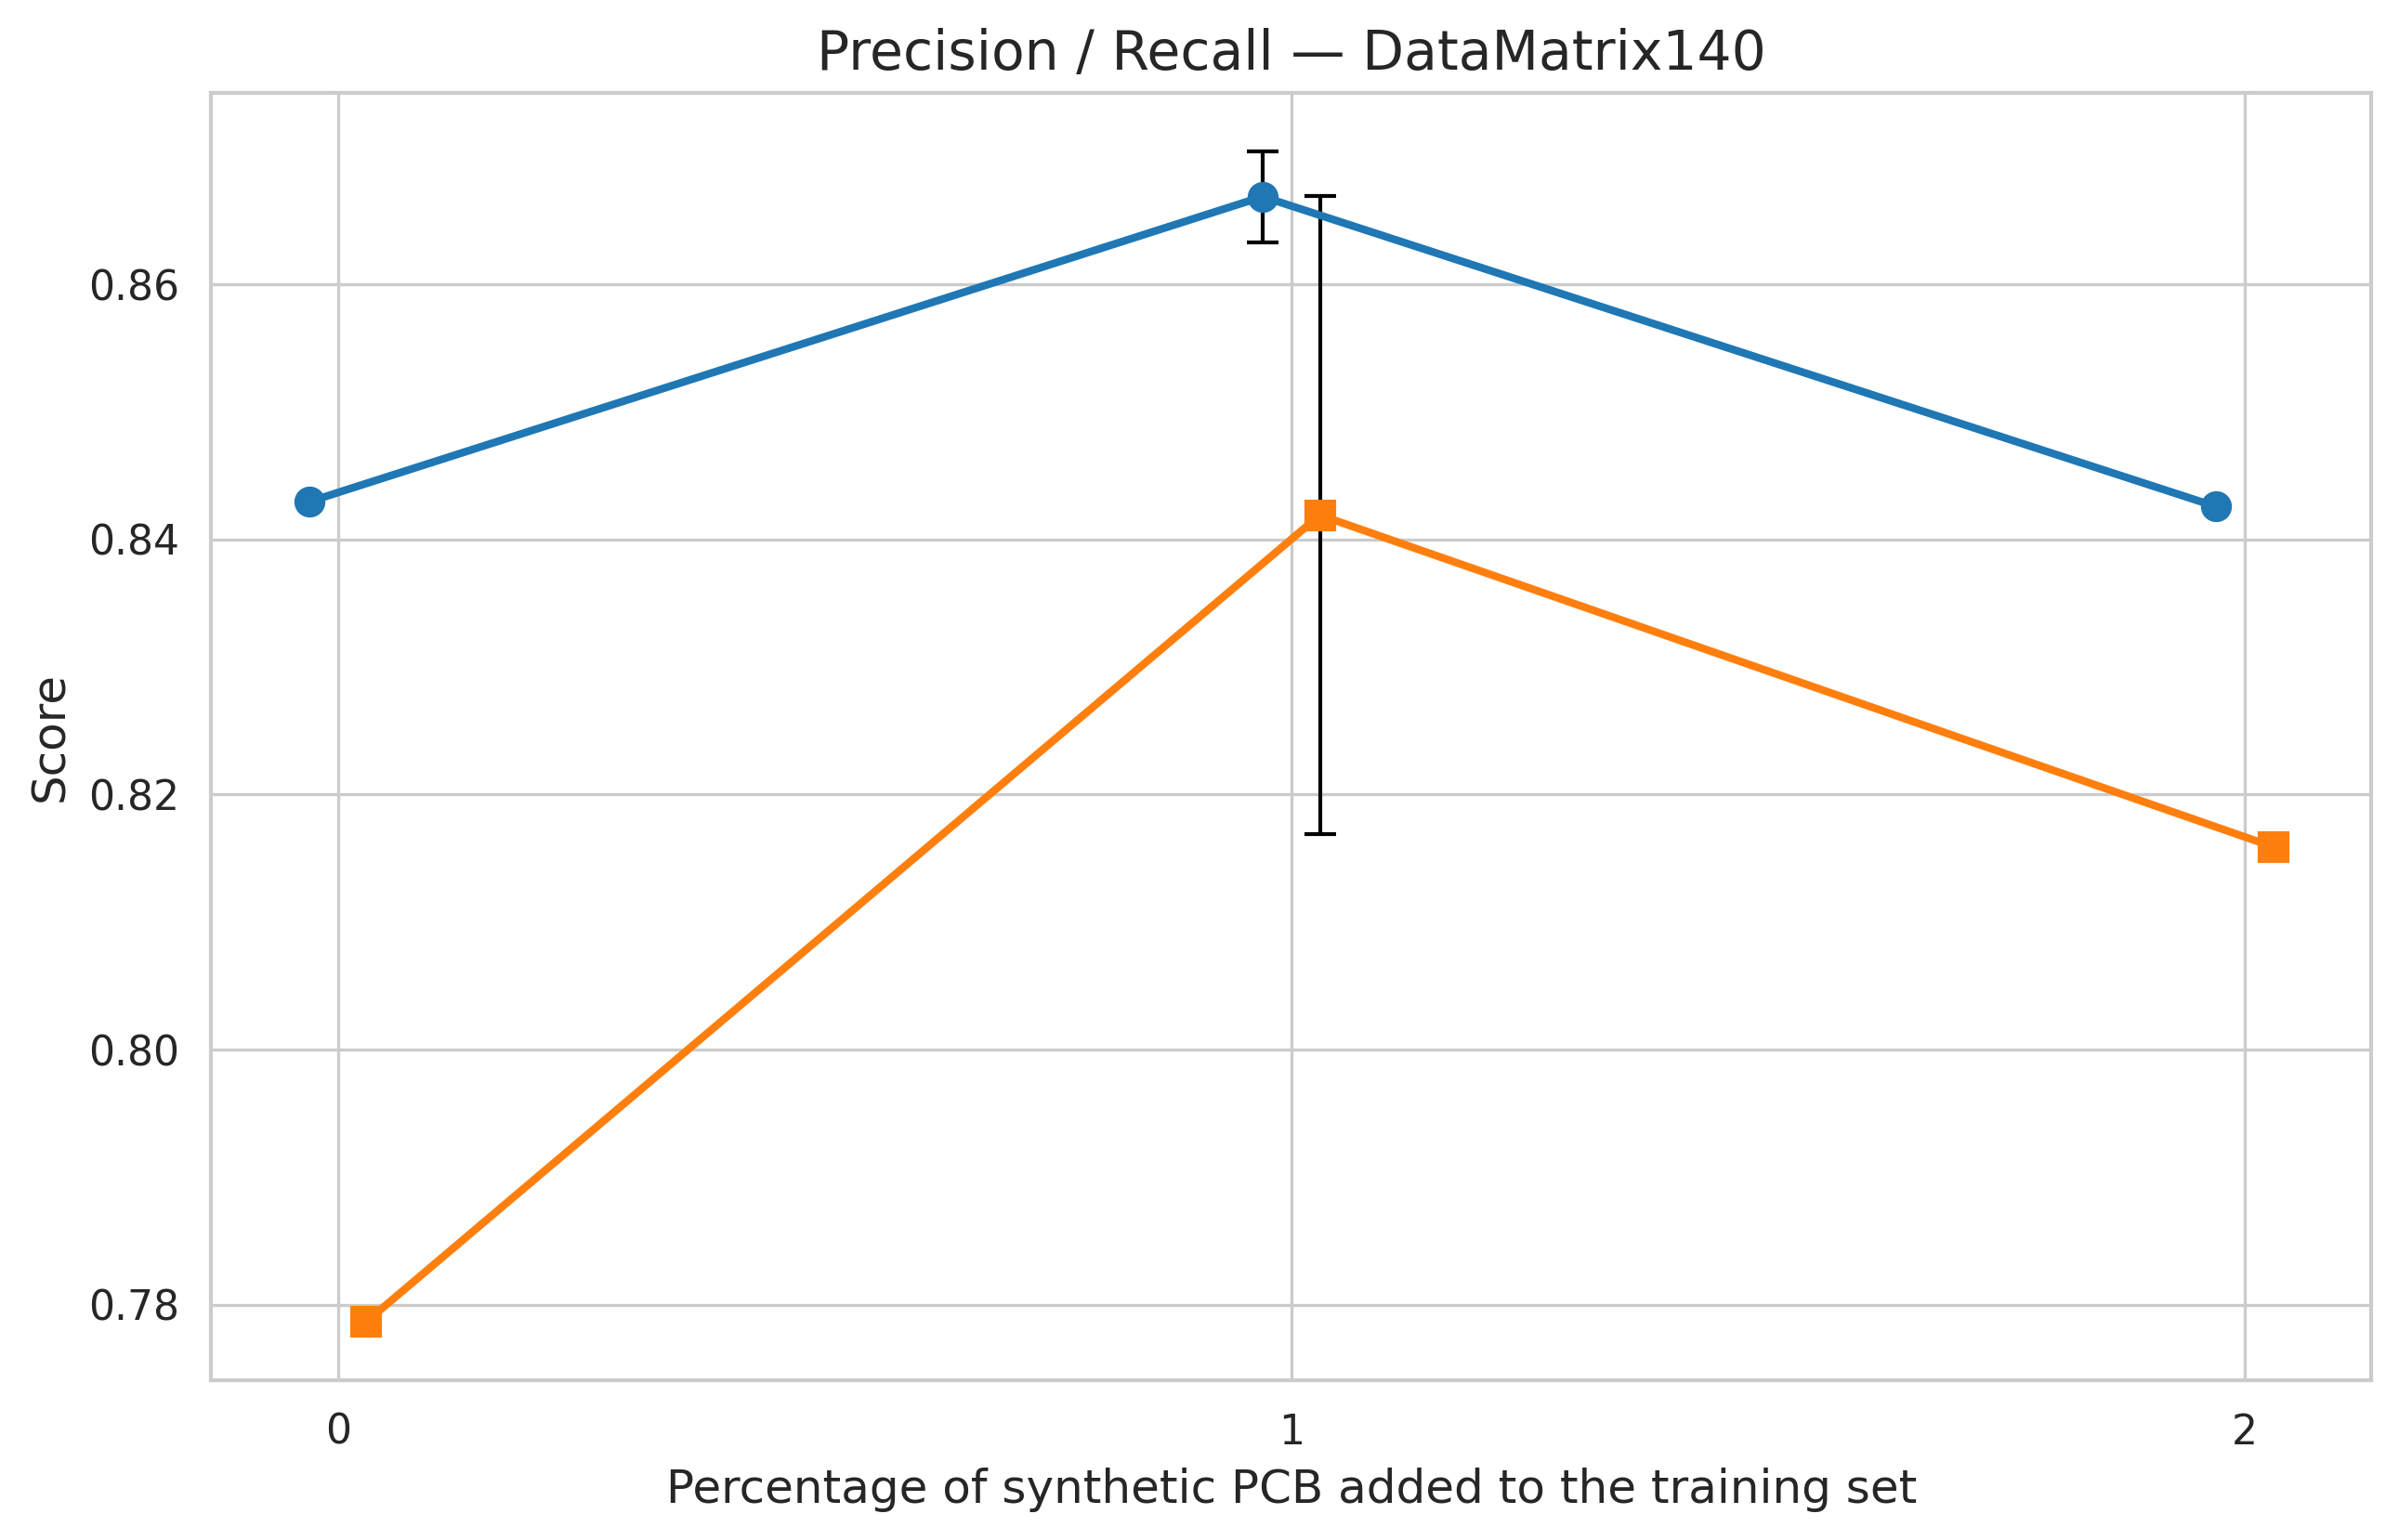

In [46]:
# Section 3 — Precision & Recall pour datamatrix140 et global

datamatrix140_stats = plot_precision_recall_for_dataset(
    "TestSet::dataset::datamatrix140",
    "DataMatrix140"
)

results_df.head(100)

global_pr_stats = plot_precision_recall_for_dataset(
    "TestSet::global::global",
    "Global (tous datasets)"
)

datamatrix140_stats, global_pr_stats
